In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Flatten, Input, concatenate
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
import tensorflow.keras.utils as utils

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score

from datetime import datetime
import cv2
import zipfile
import shutil
import os
import glob

from tensorflow.keras.applications import Xception, ResNet50, InceptionV3, MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## File Naming

In [6]:
file_path= 'content/mydog/train/'

In [7]:
label_name_list= os.listdir(file_path)
print(label_name_list)

['chihuahua', 'jindodog', 'shepherd', 'yorkshire_terrier']


In [13]:
for label_name in label_name_list:
    file_name= os.listdir(file_path+ label_name)
#     print(file_name)
    jpg_list= glob.glob(file_path+label_name + '/*.jpg')
    print(len(file_name), len(jpg_list))

152 152
337 337
152 152
164 164


In [18]:
# 파일명은 label_dir_name_counting.jpg
for label_name in label_name_list:
    label_dir_name= os.path.join(file_path, label_name)
    print(label_dir_name)
    
    file_list= os.listdir(label_dir_name)
    cnt=1
    for file_name in file_list:
        src_file_name= label_dir_name +'/'+ file_name
#         dst_file_name= label_dir_name +'/'+ label_name +'_'+ str(cnt) +'.jpg'
        dst_file_name= f'{label_dir_name}/{label_name}_{cnt}.jpg'
        os.rename(src_file_name, dst_file_name)
        cnt= cnt+1

content/mydog/train/chihuahua
content/mydog/train/jindodog
content/mydog/train/shepherd
content/mydog/train/yorkshire_terrier


## Progect-1
### 경로 설정

In [19]:
ROOT_DIR= 'content'

In [20]:
if os.path.exists(os.path.join(ROOT_DIR, 'mydog')):
    shutil.rmtree(os.path.join(ROOT_DIR, 'mydog'))
    print(os.path.join(ROOT_DIR, 'mydog')+'is deleted')
    

content\mydogis deleted


In [30]:
with zipfile.ZipFile(os.path.join(ROOT_DIR, 'mydog.zip'), 'r') as target_file:
    target_file.extractall(os.path.join(ROOT_DIR, 'mydog'))

In [31]:
label_name_list= os.listdir(os.path.join(ROOT_DIR, 'mydog/train/'))
print('total:',len(label_name_list))
print('---------------------')
print(label_name_list)

total: 4
---------------------
['chihuahua', 'jindodog', 'shepherd', 'yorkshire_terrier']


In [32]:
# test 디렉토리와 test_image_files디렉토리 생성
# train에서 test 디렉토리로 move
# test에서 test_image_files로 copy

if not os.path.exists(os.path.join(ROOT_DIR, "mydog/test")):
    os.mkdir(os.path.join(ROOT_DIR, "mydog/test"))
    
if not os.path.exists(os.path.join(ROOT_DIR, "mydog/test_image_files")):
    os.mkdir(os.path.join(ROOT_DIR, "mydog/test_image_files"))    

### 필요한 폴더 및 파일들만 copy

In [61]:
DATA_ROOT_DIR= os.path.join(ROOT_DIR, "mydog")
TRAIN_DATA_ROOT_DIR= os.path.join(DATA_ROOT_DIR, 'train')
TEST_DATA_ROOT_DIR= os.path.join(DATA_ROOT_DIR, 'test')

#### 전체 목록 확인
total_file_list= glob.glob(os.path.join(DATA_ROOT_DIR, 'train/*'))
total_file_list

#### 정답 리스트 추출
label_name_list= [ filename.split('\\')[-1].strip() 
                  for filename in total_file_list if os.path.isdir(filename)==True]
label_name_list

# #### 각 폴더의 images 디렉토리를 train/정답 이름으로 복사
# for label_name in label_name_list:
#     src_dir_path = os.path.join (DATA_ROOT_DIR, 'train'+'/'+label_name)
#     dst_dir_path = os.path.join (DATA_ROOT_DIR, 'train'+ '/'+label_name)
#     try:
#         shutil.copytree(src_dir_path, dst_dir_path) 
#         print (label_names+' copytree is done I!')
#     except Exception as err:
#         print(str(err))

#### test폴더에 하위 폴더 만들기
for label_name in label_name_list:
    if not os.path.exists(os.path.join(TEST_DATA_ROOT_DIR, label_name)):
        os.mkdir(os.path.join(TEST_DATA_ROOT_DIR, label_name))   
        print('test/'+label_name+'is created')

In [54]:
os.path.join(DATA_ROOT_DIR, 'train')
src_dir_path

'/train/yorkshire_terrier'

### 전체 데이터 갯수 확인

In [62]:
train_label_name_list= os.listdir(TRAIN_DATA_ROOT_DIR)
print(train_label_name_list)

for label_name in train_label_name_list:
    print('train label: ', label_name, '=>',
         len(os.listdir(os.path.join(TRAIN_DATA_ROOT_DIR, label_name))))

['chihuahua', 'jindodog', 'shepherd', 'yorkshire_terrier']
train label:  chihuahua => 152
train label:  jindodog => 337
train label:  shepherd => 152
train label:  yorkshire_terrier => 164


### 각각의 정답별로 원하는 비율만큼 trian -> test로 move

In [63]:
label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)

MOVE_RATIO= 0.2
for label_name in label_name_list:
    # 파일 move 하기 위한 src_dir_path, dst_dir_path 설정
    #=========================================================
    src_dir_path = os.path.join(TRAIN_DATA_ROOT_DIR,label_name)  
    dst_dir_path = os.path.join(TEST_DATA_ROOT_DIR,label_name)  
    #=========================================================

    train_data_file_list = os.listdir(src_dir_path)
    print('========================================================================')
    print('total [%s] data file nums => [%s]' % (label_name ,
                                                 len(train_data_file_list)))

    # data shuffle
    np.random.shuffle(train_data_file_list)     
    split_num = int(MOVE_RATIO*len(train_data_file_list))
    
    # extract test data from train data
    test_data_file_list = train_data_file_list[0:split_num]

    move_nums = 0
    for test_data_file in test_data_file_list:
        try:
            shutil.move(os.path.join(src_dir_path, test_data_file),
                        os.path.join(dst_dir_path, test_data_file))   
        except Exception as err:
            print(str(err))

        move_nums = move_nums + 1

    print('total move nums => ', move_nums)
    print('========================================================================')

total [chihuahua] data file nums => [152]
total move nums =>  30
total [jindodog] data file nums => [337]
total move nums =>  67
total [shepherd] data file nums => [152]
total move nums =>  30
total [yorkshire_terrier] data file nums => [164]
total move nums =>  32


### 데이터 갯수 확인

In [64]:
#### 훈련 데이터 갯수
# list= os.listdir(TRAIN_DATA_ROOT_DIR)
# for file in list:
#     print(len(os.listdir(TRAIN_DATA_ROOT_DIR+'/'+file)))

train_label_name_list= os.listdir(TRAIN_DATA_ROOT_DIR)
print(train_label_name_list)

for label_name in train_label_name_list:
    print('train label: ', label_name, '=>',
         len(os.listdir(os.path.join(TRAIN_DATA_ROOT_DIR, label_name))))
          
print('=================================')
#### 테스트 데이터 갯수

test_label_name_list= os.listdir(TEST_DATA_ROOT_DIR)
print(test_label_name_list)

for label_name in test_label_name_list:
    print('train label: ', label_name, '=>',
         len(os.listdir(os.path.join(TEST_DATA_ROOT_DIR, label_name))))

print('=================================')

['chihuahua', 'jindodog', 'shepherd', 'yorkshire_terrier']
train label:  chihuahua => 122
train label:  jindodog => 270
train label:  shepherd => 122
train label:  yorkshire_terrier => 132
['chihuahua', 'jindodog', 'shepherd', 'yorkshire_terrier']
train label:  chihuahua => 30
train label:  jindodog => 67
train label:  shepherd => 30
train label:  yorkshire_terrier => 32


### Image Shape 설정

In [65]:
IMG_WIDTH= 100 # Colab에선 224
IMG_HEIGHT= 100

### ImageDataGenerator 를 이용하여 데이터 불러오기

In [66]:
train_datagen= ImageDataGenerator(rescale= 1./255, validation_split=0.2)
val_datagen= ImageDataGenerator(rescale= 1./255, validation_split=0.2)
test_datagen= ImageDataGenerator(rescale= 1./255)


train_generator= train_datagen.flow_from_directory(directory=TRAIN_DATA_ROOT_DIR, 
                                                batch_size=32,
                                                color_mode='rgb',
                                                shuffle= True, 
                                                target_size=(IMG_HEIGHT, IMG_WIDTH), 
                                                class_mode='sparse',
                                                   subset= 'training')

val_generator= val_datagen.flow_from_directory(directory=TRAIN_DATA_ROOT_DIR, 
                                              batch_size=32,
                                              color_mode='rgb',
                                              shuffle= True, 
                                              target_size=(IMG_HEIGHT, IMG_WIDTH), 
                                              class_mode='sparse',
                                                 subset= 'validation')

test_generator= test_datagen.flow_from_directory(directory=TEST_DATA_ROOT_DIR, 
                                              batch_size=32,
                                              color_mode='rgb',
                                              shuffle= True, 
                                              target_size=(IMG_HEIGHT, IMG_WIDTH), 
                                              class_mode='sparse')

Found 518 images belonging to 4 classes.
Found 128 images belonging to 4 classes.
Found 159 images belonging to 4 classes.


In [67]:
print(train_generator.class_indices)
print(test_generator.num_classes)

{'chihuahua': 0, 'jindodog': 1, 'shepherd': 2, 'yorkshire_terrier': 3}
4


### 16장의 이미지 확인
- ImageDataGenerator를 통해 전달된 이미지 출력

In [36]:
data, label= train_generator.next()

data= data[:16]
label= label[:16]

print(data.shape, label.shape) 
print(label)

(16, 100, 100, 3) (16,)
[2. 2. 2. 1. 2. 1. 2. 2. 1. 2. 2. 3. 3. 0. 1. 1.]


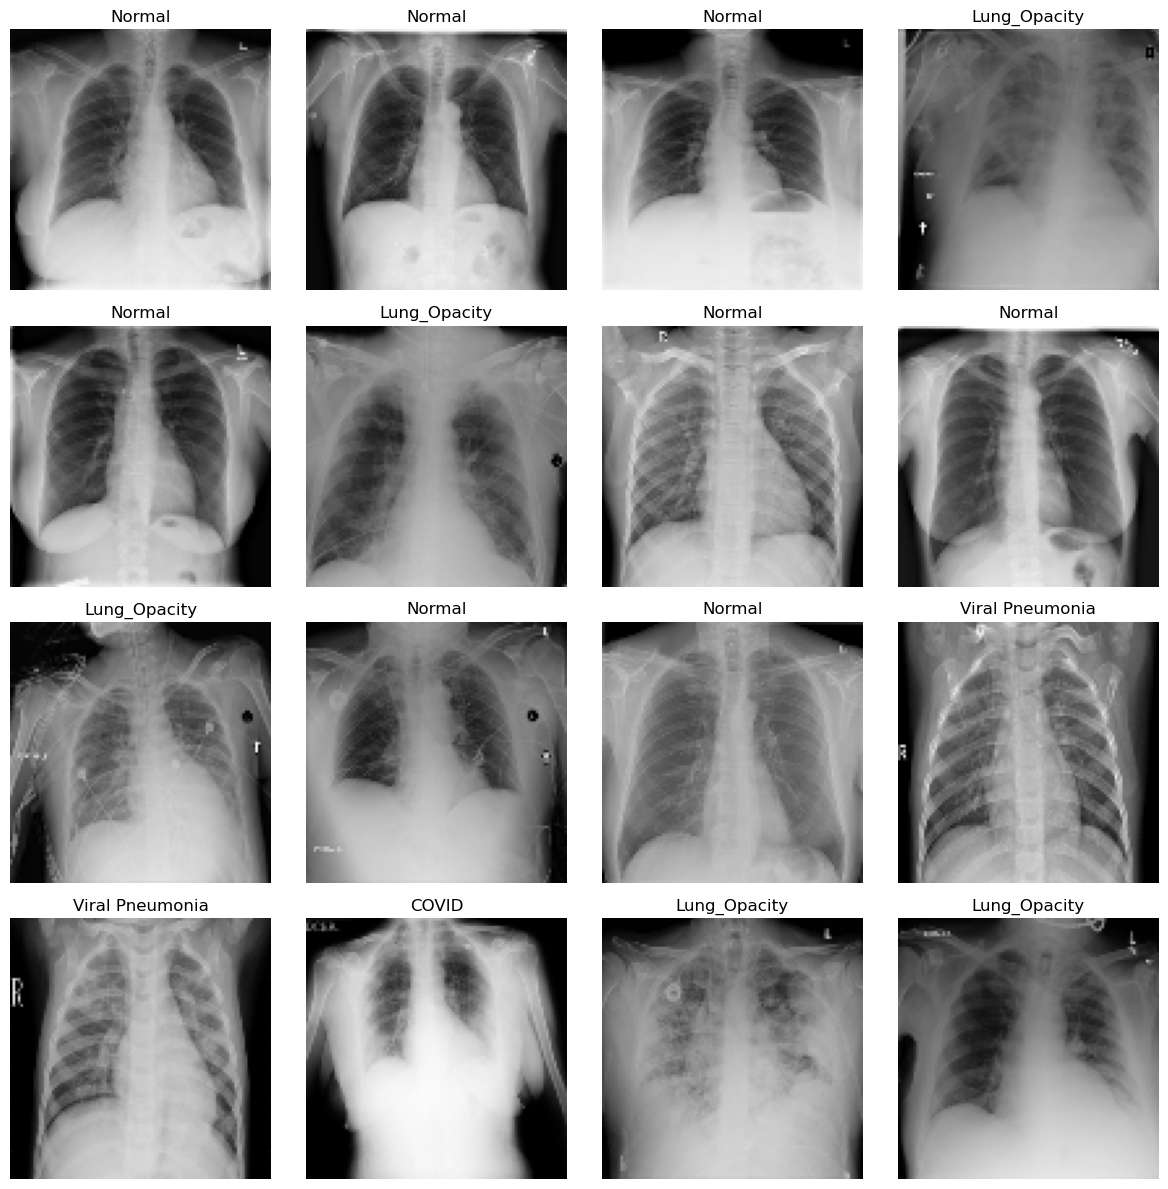

In [37]:
plt.figure(figsize=(12,12))

class_dict={0:'COVID', 1:'Lung_Opacity', 2:'Normal', 3:'Viral Pneumonia'}

for i in range(len(label)):
    plt.subplot(4,4,i+1)
    plt.axis('off')
    plt.title(class_dict[label[i]])
    plt.imshow(data[i])
    
plt.tight_layout()

### Fine Tunning을 위한 pre-trained 정의 및 모델 구축

In [68]:
pre_trained_model= MobileNet(weights='imagenet', include_top=False,
                            input_shape= (IMG_WIDTH, IMG_HEIGHT,3)) # Xception
pre_trained_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 50, 50, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 50, 50, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 50, 50, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 50, 50, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 50, 50, 32)       128       
 ation)                                         

                                                                 
 conv_pw_8 (Conv2D)          (None, 6, 6, 512)         262144    
                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 6, 6, 512)        2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 6, 6, 512)         0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 6, 6, 512)        4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 6, 6, 512)        2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 6, 6, 512)         0         
                                                                 
 conv_pw_9

In [69]:
model= Sequential()

model.add(pre_trained_model)

model.add(GlobalAveragePooling2D())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 3, 3, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 64)                65600     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Total params: 3,294,724
Trainable params: 3,272,836
Non-

In [70]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(1e-4), metrics=['acc']) # colab: lr=2e-5

In [71]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
save_file_name= './COVID-19_Radiography_MobileNet_Colab.h5'

checkpoint = ModelCheckpoint(save_file_name, # 파일명을 지정
                             monitor='val_loss', # val_loss값이 개선되었을때
                             verbose= 1, # 로그를 출력
                             save_best_only=True, # 가장 best값만 저장
                             mode='auto') # auto는 알아서 best를 찾음
earlystopping = EarlyStopping(monitor='val_loss', # 모니터 기준 설정(val loss)
                              patience=5, # 3회 epoch동안 새건되지 않는
                              verbose=1)

In [72]:
start_time= datetime.now()

result= model.fit(train_generator, epochs=3, validation_data=val_generator) # colab: epoch=30
end_time= datetime.now()
print('걸린시간: ', end_time - start_time)

Epoch 1/3
17/17 [==============================] - 12s 441ms/step - loss: 2.3569 - acc: 0.3031 - val_loss: 1.1852 - val_acc: 0.6562
Epoch 2/3
17/17 [==============================] - 6s 375ms/step - loss: 1.0333 - acc: 0.6274 - val_loss: 1.0951 - val_acc: 0.6641
Epoch 3/3
17/17 [==============================] - 7s 414ms/step - loss: 0.6966 - acc: 0.7278 - val_loss: 0.9773 - val_acc: 0.6719
걸린시간:  0:00:25.869676


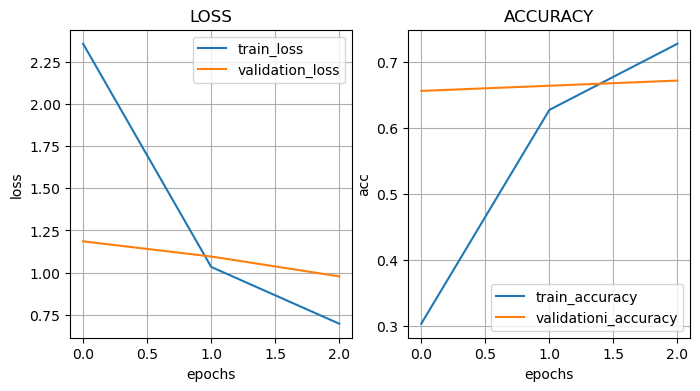

In [73]:
#### 그래프
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)

plt.title('LOSS')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()

plt.plot(result.history['loss'], label='train_loss')
plt.plot(result.history['val_loss'], label= 'validation_loss')
plt.legend(loc='best')

plt.subplot(1,2,2)

plt.title('ACCURACY')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.grid()

plt.plot(result.history['acc'], label='train_accuracy')
plt.plot(result.history['val_acc'], label= 'validationi_accuracy')
plt.legend(loc='best')

In [34]:
model.evaluate(test_generator)

133/133 [==============================] - 11s 86ms/step - loss: 0.2951 - acc: 0.8984


[0.29511797428131104, 0.8983932137489319]